## Import

In [13]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import timm
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import psutil
import os
import platform
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Device Setup & Reproducibility

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

# Optional: set seeds
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)

output_dir = "PiT Tiny"
os.makedirs(output_dir, exist_ok=True)

✅ Using device: cuda


## Data Preparation

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    normalize
])

# Load datasets
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Test: {len(test_dataset)} images")

✅ Test: 10000 images


## Model Setup – Load Pretrained

In [4]:
# Load PiT Tiny from timm (pretrained on ImageNet-1k)
print("📥 Loading PiT Tiny from timm...")
model = timm.create_model(
    'pit_ti_distilled_224.in1k',
    pretrained=True,
    num_classes=10
)

# Freeze all but the head
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

model = model.to(device)
print("✅ Model output shape test:", model(torch.randn(1, 3, 224, 224).to(device)).shape)

📥 Loading PiT Tiny from timm...
✅ Model output shape test: torch.Size([1, 10])


In [5]:
def get_model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / (1024 ** 2)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params
model_size_mb = get_model_size_mb(model)

print("=== MODEL PARAMETER ===")
print(f"• Total Parameters:         {total_params:,}")
print(f"• Trainable Parameters:     {trainable_params:,}")
print(f"• Non-Trainable Parameters: {non_trainable_params:,}")
print(f"• Model Size (FP32):        {model_size_mb:.2f} MB")

=== MODEL PARAMETER ===
• Total Parameters:         4,595,476
• Trainable Parameters:     5,140
• Non-Trainable Parameters: 4,590,336
• Model Size (FP32):        17.53 MB


## Performance Metrics

✅ Saved figure to PiT Tiny\samples.png


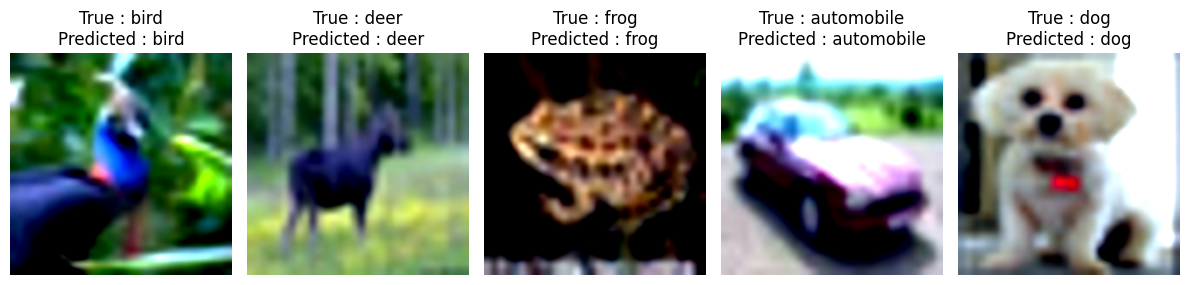

In [6]:
model_path = os.path.join(output_dir, "pit_tiny_cifar10_best.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Get predictions
all_preds, all_labels, all_images = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = probs.max(1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Convert to numpy arrays
all_images = torch.stack(all_images).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Show 5 random samples
idxs = np.random.choice(len(all_labels), 5, replace=False)
plt.figure(figsize=(12, 4))
for i, idx in enumerate(idxs):
    img = np.transpose(all_images[idx], (1, 2, 0))  # C,H,W → H,W,C
    img = np.clip((img * 0.5 + 0.5), 0, 1)

    true_label = class_names[all_labels[idx]]
    pred_label = class_names[all_preds[idx]]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True : {true_label}\nPredicted : {pred_label}")

plt.tight_layout()
save_path = os.path.join(output_dir, "samples.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"✅ Saved figure to {save_path}")
plt.show()

In [7]:
# Save to CSV
df = pd.DataFrame({
    'image_id': list(range(len(all_labels))),
    'true_label': [class_names[i] for i in all_labels],
    'predicted_label': [class_names[i] for i in all_preds],
})
csv_path = os.path.join(output_dir, "predictions.csv")
df.to_csv(csv_path, index=False)
print("✅ Predictions saved to 'predictions.csv'")

✅ Predictions saved to 'predictions.csv'


In [8]:
acc = accuracy_score(all_labels, all_preds)
prec_macro = precision_score(all_labels, all_preds, average='macro')
rec_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print("\n=== PERFORMANCE METRICS ===")
print(f"• Overall Accuracy: {acc:.4f} ({100*acc:.2f}%)")
print(f"• Macro Precision:  {prec_macro:.4f}")
print(f"• Macro Recall:     {rec_macro:.4f}")
print(f"• Macro F1-Score:   {f1_macro:.4f}")

# Per-class
prec_per = precision_score(all_labels, all_preds, average=None)
rec_per = recall_score(all_labels, all_preds, average=None)
f1_per = f1_score(all_labels, all_preds, average=None)

print("\n• Per-Class Metrics:")
print("Class\t\tPrecision\tRecall\t\tF1")
for i, name in enumerate(class_names):
    print(f"{name:<12}\t{prec_per[i]:.4f}\t\t{rec_per[i]:.4f}\t\t{f1_per[i]:.4f}")


=== PERFORMANCE METRICS ===
• Overall Accuracy: 0.9201 (92.01%)
• Macro Precision:  0.9203
• Macro Recall:     0.9201
• Macro F1-Score:   0.9201

• Per-Class Metrics:
Class		Precision	Recall		F1
airplane    	0.9223		0.9140		0.9181
automobile  	0.9533		0.9590		0.9561
bird        	0.9338		0.8890		0.9109
cat         	0.8443		0.8730		0.8584
deer        	0.9052		0.9070		0.9061
dog         	0.8989		0.8800		0.8893
frog        	0.9299		0.9550		0.9423
horse       	0.9289		0.9400		0.9344
ship        	0.9390		0.9390		0.9390
truck       	0.9478		0.9450		0.9464


## Confusion Matrix

✅ Saved figure to PiT Tiny\confusion.png


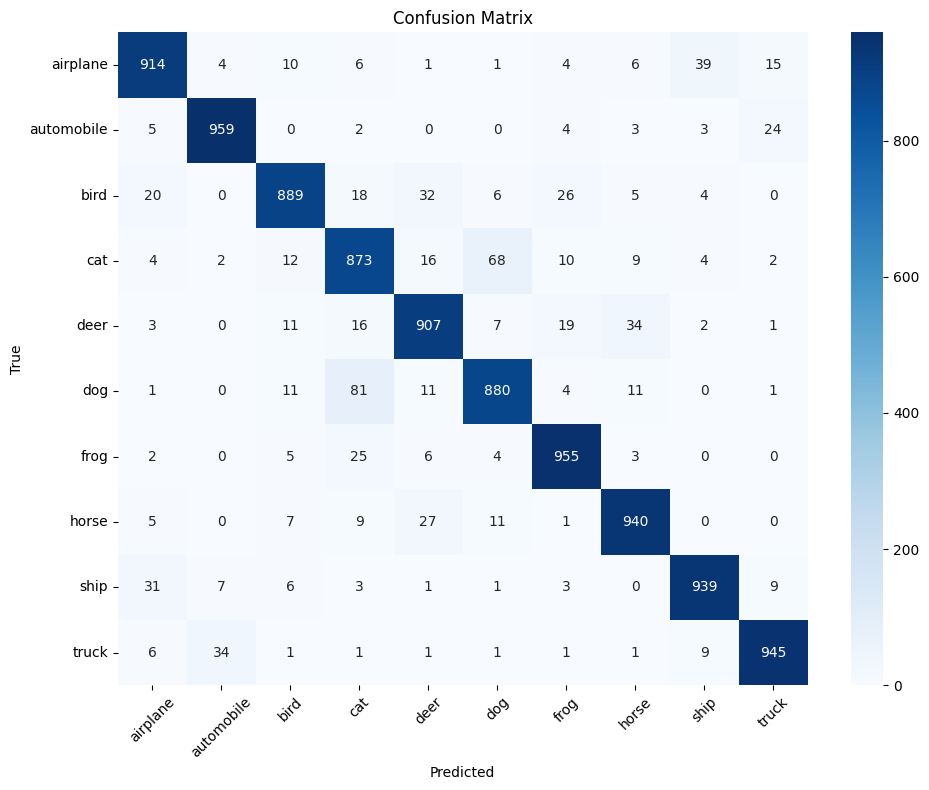

In [9]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
save_path = os.path.join(output_dir, "confusion.png")
plt.savefig(save_path, dpi=200, bbox_inches='tight')
print(f"✅ Saved figure to {save_path}")
plt.show()

## Inference

In [10]:
# Warm-up
model.eval()
with torch.no_grad():
    for _ in range(10):
        x, _ = next(iter(test_loader))
        x = x.to(device)
        _ = model(x)

# Timed inference on full test set
start_time = time.time()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        _ = model(x)
end_time = time.time()

total_time = end_time - start_time
total_images = len(test_dataset)
avg_time_per_image_ms = (total_time / total_images) * 1000
throughput = total_images / total_time

print("=== INFERENCE TIME ===")
print(f"• Total test images:       {total_images}")
print(f"• Total inference time:    {total_time:.3f} sec")
print(f"• Avg. time per image:     {avg_time_per_image_ms:.3f} ms")
print(f"• Throughput:              {throughput:.2f} images/sec")

# Hardware info
if torch.cuda.is_available():
    # NVIDIA GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"• Hardware:                GPU - {gpu_name}")
elif torch.backends.mps.is_available():
    # Apple Silicon (M1/M2/M3)
    print("• Hardware:                Apple MPS (Metal Performance Shaders)")
else:
    # CPU fallback
    cpu_count = psutil.cpu_count(logical=False)
    cpu_name = platform.processor() or "Unknown CPU"
    print(f"• Hardware:                CPU - {cpu_name} ({cpu_count} cores)")

=== INFERENCE TIME ===
• Total test images:       10000
• Total inference time:    8.872 sec
• Avg. time per image:     0.887 ms
• Throughput:              1127.17 images/sec
• Hardware:                GPU - NVIDIA GeForce RTX 5060 Laptop GPU
